#Importing Libraries

---

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import glob
from itertools import groupby
import matplotlib.pyplot as plt
from fastai import *
from fastai.vision import *
from google.colab import drive
import pandas as pd
import numpy as np
import collections

# **Importing Our Dataset**

---


In [8]:
# Mounting Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Path to paintings directory 
paintings_path = "/content/drive/My Drive/Colab Notebooks/dataset"

# Extracting artist names
artists_file_path = glob.glob(paintings_path + '/*.jpg')

In [0]:
# Storing list of artist names
list_of_artists = []


for filename in artists_file_path:
    artist_name = ""
    artist_path = (filename.split("/")[6].split("_"))[0:-1]
    for item in artist_path:
        artist_name = artist_name + " " + item
    list_of_artists.append(artist_name)

In [0]:
# Storing frequency of paintings per artist
artist_frequency = {value: len(list(freq)) for value, freq in groupby(sorted(list_of_artists))}
sorted_artist_frequency = OrderedDict(sorted(artist_frequency.items(), key=lambda t: t[1]))

# Analyzing Our Dataset

In [12]:
print("Number of Artists: " + str(len(artist_frequency)))
print("Maxmimum Number of Paintigs Per Artist: " + str(max(artist_frequency.values())))
print("Minimum Number of Paintigs Per Artitst: " + str(min(artist_frequency.values())))

Number of Artists: 5
Maxmimum Number of Paintigs Per Artist: 300
Minimum Number of Paintigs Per Artitst: 300


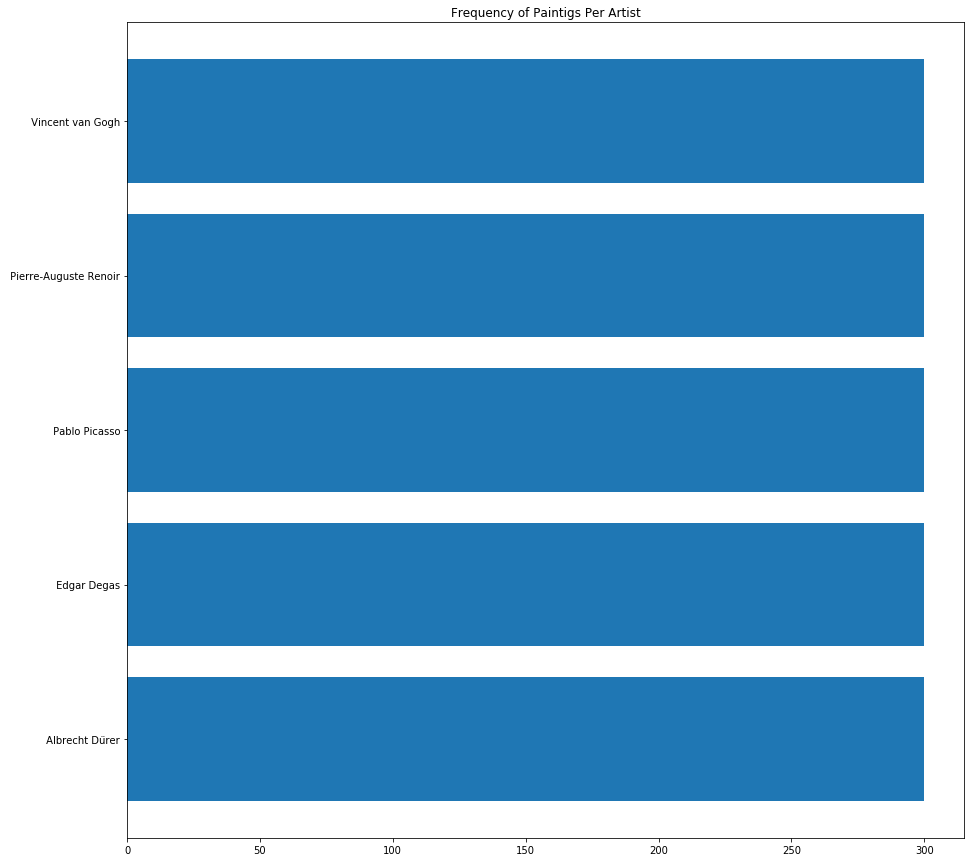

In [13]:
# Horizontal Bar Graph of Frequency of Paintigs Per Artist
artists = list(sorted_artist_frequency.keys())
frequency = list(sorted_artist_frequency.values())

x_pos = range(len(sorted_artist_frequency))

plt.figure(figsize=(15,15))
plt.barh(x_pos, frequency)
plt.title("Frequency of Paintigs Per Artist")

plt.yticks(x_pos, artists)

plt.show()

# Training The Model

In [14]:
# do_Flip = True --> images are being trained flipped and in several rotations

artist_names = get_image_files(paintings_path)

data = ImageDataBunch.from_name_re(
    paintings_path,
    artist_names,
    r'/([^/]+)_\d+.jpg$',
    ds_tfms=get_transforms(),
    size=224,
    num_workers=0
)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (1200 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Vincent_van_Gogh,Vincent_van_Gogh,Vincent_van_Gogh,Vincent_van_Gogh,Vincent_van_Gogh
Path: /content/drive/My Drive/Colab Notebooks/dataset;

Valid: LabelList (300 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Edgar_Degas,Albrecht_Dürer,Albrecht_Dürer,Pablo_Picasso,Pablo_Picasso
Path: /content/drive/My Drive/Colab Notebooks/dataset;

Test: None

In [0]:
defaults.device = torch.device('cuda')

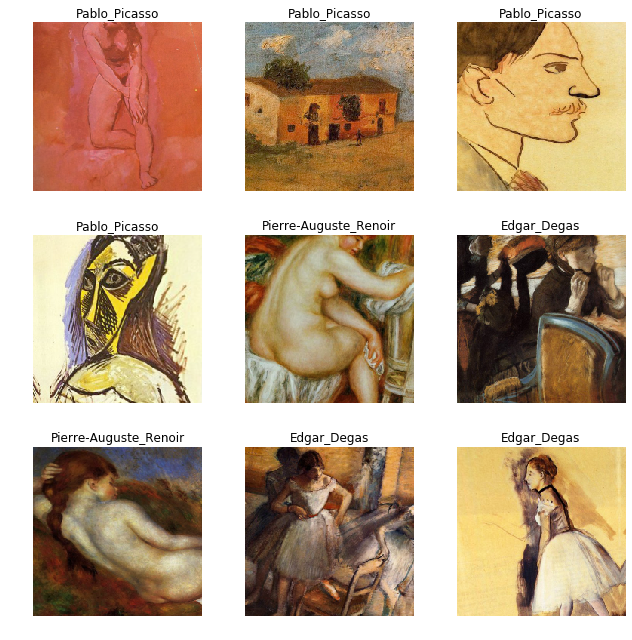

In [16]:
# Previewing a sample batch
data.show_batch(rows=3, figsize=(9,9))

In [17]:
# Printing Classes
data.classes

['Albrecht_Dürer',
 'Edgar_Degas',
 'Pablo_Picasso',
 'Pierre-Auguste_Renoir',
 'Vincent_van_Gogh']

### RESNET 152

In [18]:
# Using resnet152 --> transfer learning
# Metrics --> error_rate,accuracy,mean_squared_error,top_k_accuracy,r2_score
artist_identification = cnn_learner(data, models.resnet50, metrics=(error_rate,accuracy), 
                                    model_dir='/content/drive/My Drive/Colab Notebooks/models')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 94976814.24it/s]


In [19]:
artist_identification.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.010649,0.488165,0.173333,0.826667,04:50
1,0.662741,0.380300,0.130000,0.870000,01:03
2,0.502659,0.381853,0.130000,0.870000,00:54


In [0]:
artist_identification.save('version_50n_1.0')

In [0]:
#Initiating refit and checking LR
artist_identification.load('version_50n_1.0')
artist_identification.unfreeze()
artist_identification.lr_find() 

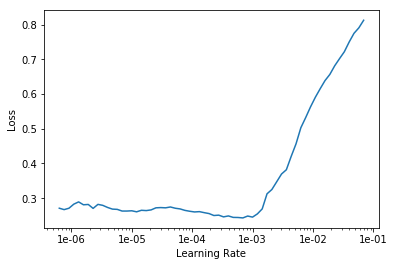

In [22]:
artist_identification.recorder.plot()

In [23]:
#The lowest loss is at 1e-06 and loss increases from after 1e-04. Refitting by modulating LR
artist_identification.fit_one_cycle(2,max_lr=slice(1e-05,1e-04))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.283657,0.347034,0.126667,0.873333,00:57
1,0.241892,0.323231,0.113333,0.886667,00:57


In [0]:
artist_identification.save('version_50n_1.0')

In [0]:
artist_identification.unfreeze()
artist_identification.lr_find()

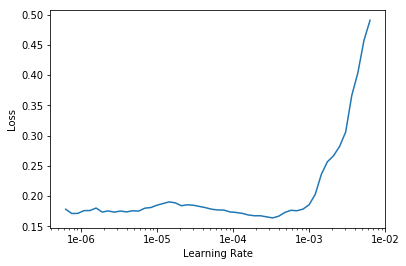

In [26]:
artist_identification.recorder.plot()

In [27]:
#The lowest loss is at 1e-06 and loss increases from after 1e-04. Refitting by modulating LR
artist_identification.fit_one_cycle(2,max_lr=slice(1e-05,1e-04))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.194461,0.311354,0.103333,0.896667,00:58
1,0.164421,0.316637,0.106667,0.893333,00:57


In [0]:
artist_identification.save('version_50n_2.0')

In [0]:
artist_identification.unfreeze()
artist_identification.lr_find()

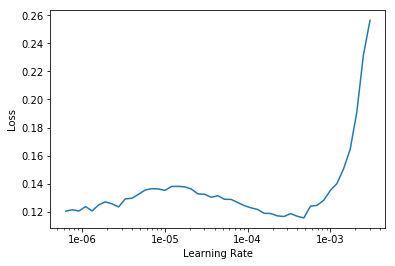

In [30]:
artist_identification.recorder.plot()

In [31]:
#The lowest loss is at 1e-06 and loss increases from after 1e-04. Refitting by modulating LR
artist_identification.fit_one_cycle(2,max_lr=slice(1e-05,1e-04))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.108449,0.306474,0.103333,0.896667,00:58
1,0.103435,0.300979,0.090000,0.910000,00:56


In [0]:
artist_identification.save('version_50n_3.0')

In [0]:
artist_identification.unfreeze()
artist_identification.lr_find()

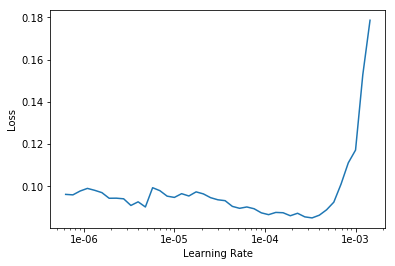

In [34]:
artist_identification.recorder.plot()

In [35]:
artist_identification.fit_one_cycle(2,max_lr=slice(1e-06,1e-05))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.097885,0.302881,0.090000,0.910000,00:57
1,0.095164,0.299916,0.093333,0.906667,00:56


In [0]:
artist_identification.save('version_50n_4.0')

In [0]:
artist_identification.unfreeze()
artist_identification.lr_find()

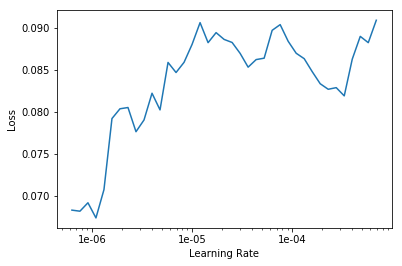

In [38]:
artist_identification.recorder.plot()

In [39]:
artist_identification.fit_one_cycle(2,max_lr=slice(1e-05,1e-04))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.093769,0.307103,0.096667,0.903333,00:57
1,0.093937,0.299099,0.093333,0.906667,00:56


In [0]:
artist_identification.save('version_50n_5.0')

In [0]:
interp = ClassificationInterpretation.from_learner(artist_identification)

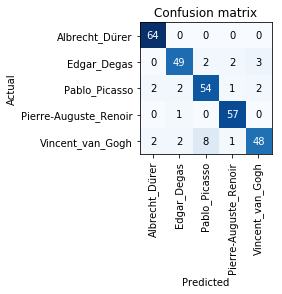

In [42]:
interp.plot_confusion_matrix()

In [43]:
interp.most_confused()

[('Vincent_van_Gogh', 'Pablo_Picasso', 8),
 ('Edgar_Degas', 'Vincent_van_Gogh', 3),
 ('Edgar_Degas', 'Pablo_Picasso', 2),
 ('Edgar_Degas', 'Pierre-Auguste_Renoir', 2),
 ('Pablo_Picasso', 'Albrecht_Dürer', 2),
 ('Pablo_Picasso', 'Edgar_Degas', 2),
 ('Pablo_Picasso', 'Vincent_van_Gogh', 2),
 ('Vincent_van_Gogh', 'Albrecht_Dürer', 2),
 ('Vincent_van_Gogh', 'Edgar_Degas', 2),
 ('Pablo_Picasso', 'Pierre-Auguste_Renoir', 1),
 ('Pierre-Auguste_Renoir', 'Edgar_Degas', 1),
 ('Vincent_van_Gogh', 'Pierre-Auguste_Renoir', 1)]

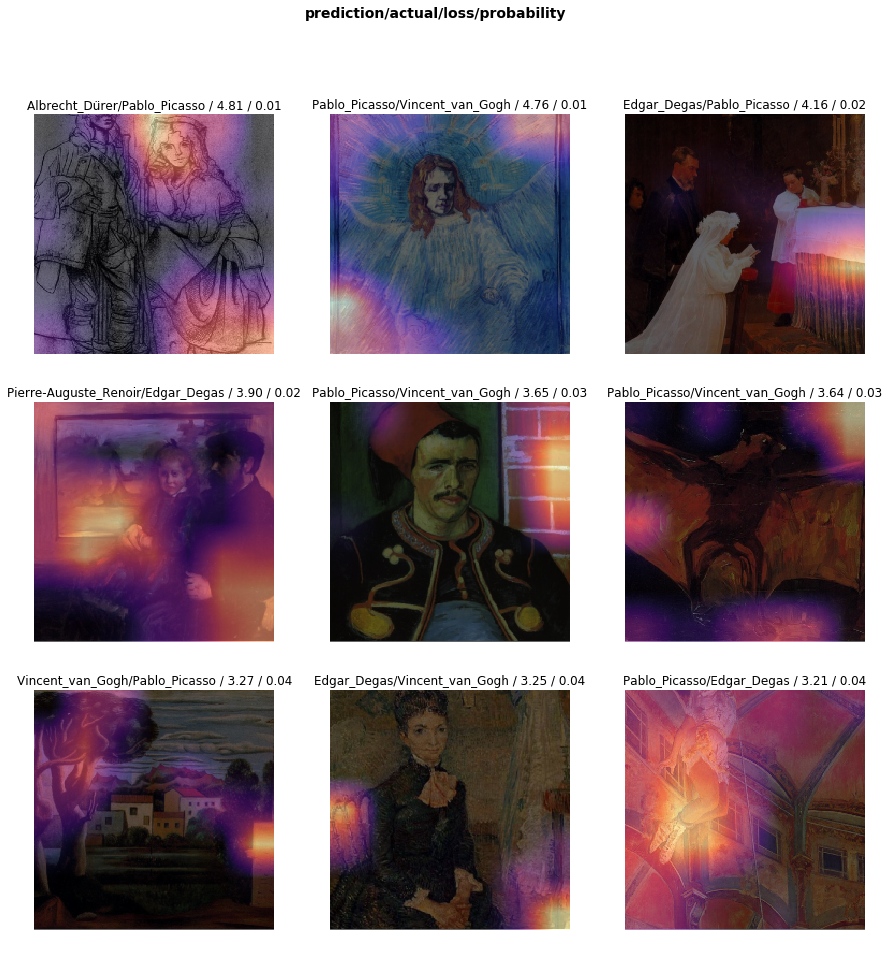

In [44]:
interp.plot_top_losses(9, figsize=(15,15))